In [32]:
# Imports & File Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

CLEANFILE = "../../MLBDATA/Processed/BatterData/ModelingBattingData.csv"

In [33]:
# 1) Load the modeling data
df = pd.read_csv(CLEANFILE)

# 4) Aggregate by Season, Handedness, and cluster using the provided OBP and BABIP columns
agg = df.groupby(['year', 'bat_side', 'cluster']).apply(
    lambda g: pd.Series({
        'PA':   g['pa'].sum(),
        'OBP':  (g['on_base_percent'] * g['pa']).sum() / g['pa'].sum(),
        'BABIP':(g['babip']             * g['pa']).sum() / g['pa'].sum(),
    })
).reset_index()

# 4) Pivot so each (Handedness, cluster) pair has its own OBP/BABIP series
pivot = agg.pivot(
    index='year',
    columns=['bat_side','cluster'],
    values=['OBP','BABIP']
).sort_index()

did_rows = []
for cluster in agg['cluster'].unique():
    for year in pivot.index:
        prev = year - 1
        if prev not in pivot.index:
            continue

        # ΔLHB and ΔRHB in OBP
        dL_obp = pivot.loc[year,  ('OBP','L',cluster)] - pivot.loc[prev, ('OBP','L',cluster)]
        dR_obp = pivot.loc[year,  ('OBP','R',cluster)] - pivot.loc[prev, ('OBP','R',cluster)]
        did_obp = dL_obp - dR_obp

        # ΔLHB and ΔRHB in BABIP
        dL_babip = pivot.loc[year,  ('BABIP','L',cluster)] - pivot.loc[prev, ('BABIP','L',cluster)]
        dR_babip = pivot.loc[year,  ('BABIP','R',cluster)] - pivot.loc[prev, ('BABIP','R',cluster)]
        did_babip = dL_babip - dR_babip

        did_rows.append({
            'cluster':    cluster,
            'Season':     year,
            'DID_OBP':    did_obp,
            'DID_BABIP':  did_babip
        })

did_df = pd.DataFrame(did_rows)

# 6) View your cluster-level Difference-in-Differences table
print(did_df)

    cluster  Season   DID_OBP  DID_BABIP
0         0    2016 -0.022316  -0.046292
1         0    2017  0.027660   0.043751
2         0    2018  0.007332   0.009493
3         0    2019 -0.026574  -0.028137
4         0    2022 -0.003028  -0.005058
5         0    2023  0.005190  -0.005150
6         0    2024  0.002739   0.005376
7         1    2016 -0.004449   0.008045
8         1    2017 -0.011306  -0.005991
9         1    2018  0.002737  -0.004506
10        1    2019  0.004882   0.018873
11        1    2022 -0.011437  -0.011095
12        1    2023  0.009643   0.015161
13        1    2024 -0.003235  -0.007525
14        2    2016 -0.027300  -0.006225
15        2    2017  0.022612  -0.016103
16        2    2018 -0.003497   0.002651
17        2    2019  0.007318   0.021683
18        2    2022 -0.001284  -0.021259
19        2    2023  0.009445   0.025812
20        2    2024 -0.012563  -0.000905


C:\Users\Andrew\AppData\Local\Temp\ipykernel_17716\3667429936.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = df.groupby(['year', 'bat_side', 'cluster']).apply(


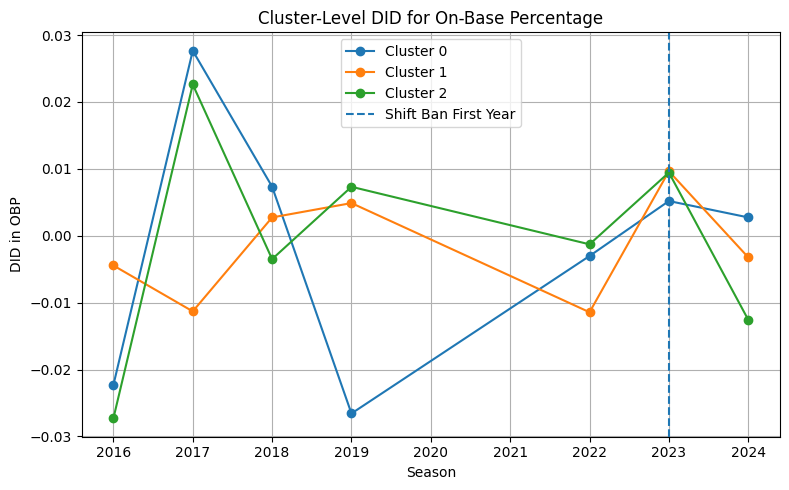

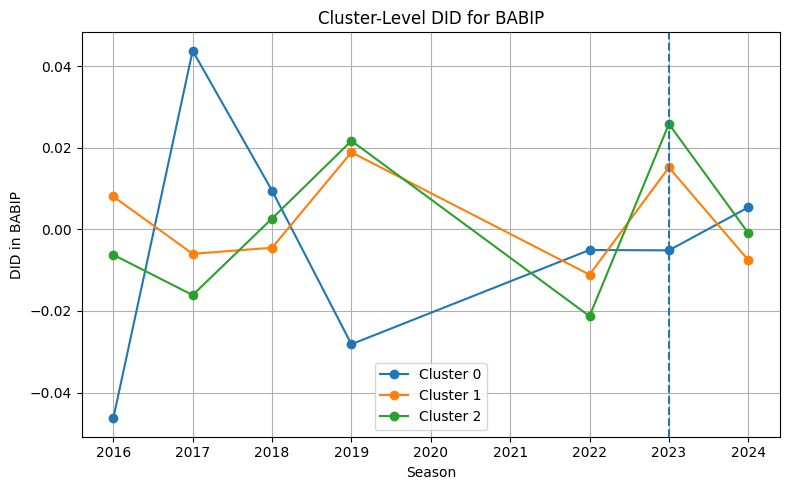

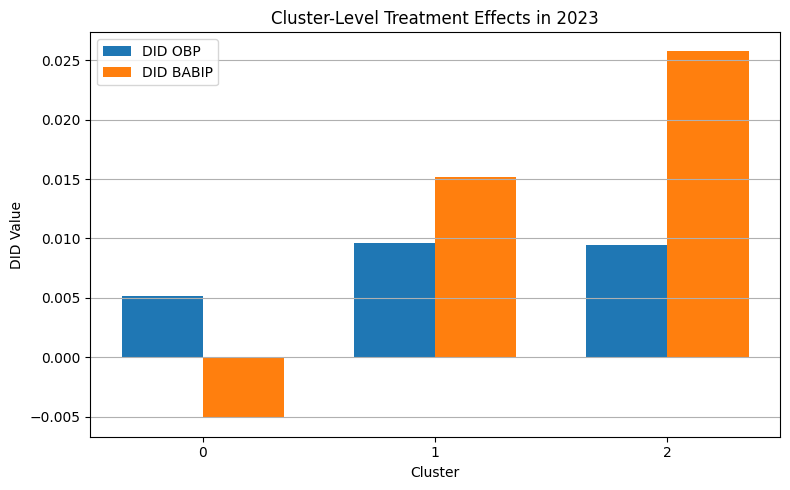

: 

In [ ]:
# 1) Line plot: DID_OBP over seasons by cluster
plt.figure(figsize=(8, 5))
for c, grp in did_df.groupby('cluster'):
    plt.plot(grp['Season'], grp['DID_OBP'], marker='o', label=f'Cluster {c}')
plt.axvline(2023, linestyle='--', label='Shift Ban First Year')
plt.xlabel('Season')
plt.ylabel('DID in OBP')
plt.title('Cluster-Level DID for On-Base Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Line plot: DID_BABIP over seasons by cluster
plt.figure(figsize=(8, 5))
for c, grp in did_df.groupby('cluster'):
    plt.plot(grp['Season'], grp['DID_BABIP'], marker='o', label=f'Cluster {c}')
plt.axvline(2023, linestyle='--')
plt.xlabel('Season')
plt.ylabel('DID in BABIP')
plt.title('Cluster-Level DID for BABIP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Bar chart: 2023 treatment effects by cluster
effect_2023 = did_df[did_df['Season'] == 2023].sort_values('cluster')
clusters = effect_2023['cluster'].astype(str)
x = np.arange(len(clusters))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, effect_2023['DID_OBP'], width, label='DID OBP')
plt.bar(x + width/2, effect_2023['DID_BABIP'], width, label='DID BABIP')
plt.xlabel('Cluster')
plt.ylabel('DID Value')
plt.title('Cluster-Level Treatment Effects in 2023')
plt.xticks(x, clusters)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
